# Capital Asset Pricing Model (CAPM)

CAPM describes the relationship between systematic risk and expected return for assets, particularly stocks. CAPM is widely used throughout finance for pricing risky securities and generating expected returns for assets given the risk of those assets and cost of capital. 

This example shows how to use CAPM to find the optimum protofolio combination based on historical data

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import yfinance as fix

In [4]:
start=datetime.date(2017,1,1)

# create portfolio with Apple, Cisco, IBM, and Amazon
AAPL=fix.download('AAPL',start)
CISCO=fix.download('CSCO',start)
IBM=fix.download('IBM',start)
AMZN=fix.download('AMZN',start)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#normalize price
for stock_df in (AAPL,CISCO,IBM,AMZN):
    stock_df['Normed Return']=stock_df['Adj Close']/stock_df.iloc[0]['Adj Close']
AAPL.head()

for stock_df,allo in zip([AAPL,CISCO,IBM,AMZN],[0.3,0.2,0.4,0.1]):
    stock_df['Allocation']=stock_df['Normed Return']*allo

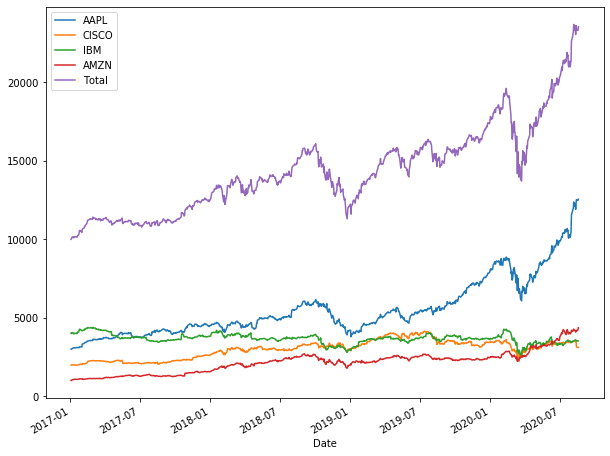

In [6]:
# Initialize investment, with origial value at 10,000
investment=10000
for stock_df in (AAPL,CISCO,IBM,AMZN):
    stock_df['Position Values']=stock_df['Allocation']*investment

portfolio=pd.concat([AAPL['Position Values'],CISCO['Position Values'],\
                     IBM['Position Values'],AMZN['Position Values']],axis=1)
portfolio.columns=['AAPL','CISCO','IBM','AMZN']
portfolio['Total']=portfolio.sum(axis=1)
portfolio.plot(figsize=(10,8))

In [7]:
# review of daily return
portfolio['Daily Return']=portfolio['Total'].pct_change(1)
print(portfolio['Daily Return'].mean())
print(portfolio['Daily Return'].std())

0.001060549100102358
0.01553532852433381


## Portfolio Optimization

In [11]:
# porftfolio optimization
stocks=pd.concat([AAPL['Adj Close'],CISCO['Adj Close'],IBM['Adj Close'],\
                  AMZN['Adj Close']],axis=1)
stocks.columns=['AAPL','CISCO','IBM','AMZN']
daily_change=stocks.pct_change(1)

In [13]:
stocks.head()

,AAPL,CISCO,IBM,AMZN
Date,,,,
2017-01-03,110.193657,27.153379,141.637695,753.669983
2017-01-04,110.070328,26.991968,143.391296,757.179993
2017-01-05,110.630081,27.054739,142.916901,780.450012
2017-01-06,111.863426,27.108545,143.620056,795.989990
2017-01-09,112.888023,27.063707,142.027374,796.919983


In [14]:
daily_change.head()

,AAPL,CISCO,IBM,AMZN
Date,,,,
2017-01-03,NaN,NaN,NaN,NaN
2017-01-04,-0.001119,-0.005944,0.012381,0.004657
2017-01-05,0.005085,0.002326,-0.003308,0.030732
2017-01-06,0.011148,0.001989,0.004920,0.019912
2017-01-09,0.009159,-0.001654,-0.011090,0.001168


In [15]:
# the correlation matric
daily_change.corr()

,AAPL,CISCO,IBM,AMZN
AAPL,1.000000,0.630786,0.548934,0.624037
CISCO,0.630786,1.000000,0.632429,0.526788
IBM,0.548934,0.632429,1.000000,0.429640
AMZN,0.624037,0.526788,0.429640,1.000000


## Mento Carlo simulation

try thousands of possible allocations to find the best portfolio combination

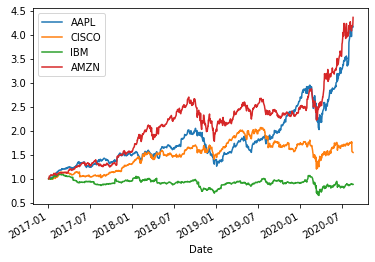

In [17]:
stock_normed=stocks/stocks.iloc[0]
stock_normed.plot()

,AAPL,CISCO,IBM,AMZN
AAPL,0.000375,0.000226,0.000184,0.000229
CISCO,0.000226,0.000343,0.000201,0.000185
IBM,0.000184,0.000201,0.000294,0.000141
AMZN,0.000229,0.000185,0.000141,0.000357


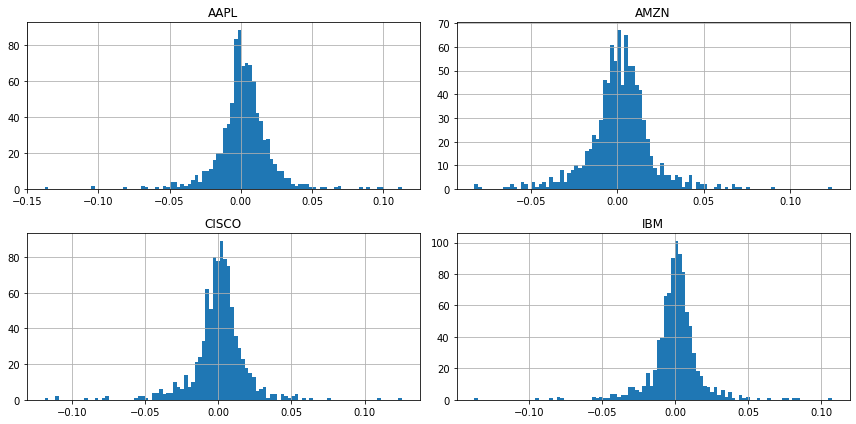

In [18]:
# log return vs arithmetic returns
log_ret=np.log(stocks/stocks.shift(1))
log_ret.head()
log_ret.hist(bins=100,figsize=(12,6))
plt.tight_layout()
log_ret.describe().transpose()
log_ret.mean()*252
log_ret.cov()

stocks
Index(['AAPL', 'CISCO', 'IBM', 'AMZN'], dtype='object')


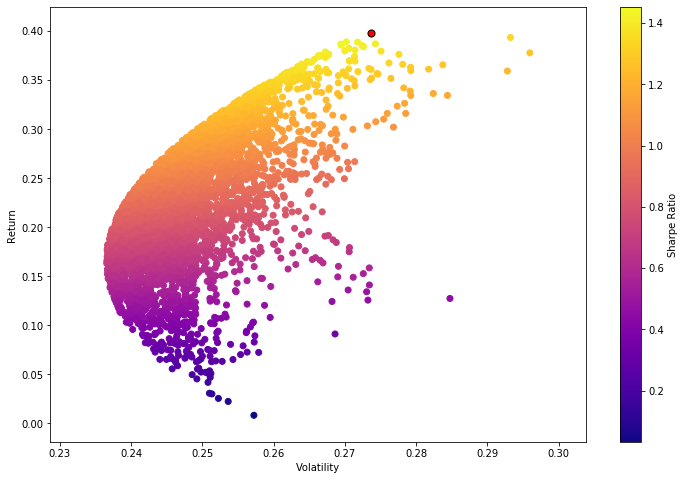

In [20]:
# ******singel run from some random allocation
np.random.seed(101)
print('stocks')
print(stocks.columns)

# funcitons
def assignWeight(NumOfStocks):
    weights=np.array(np.random.random(NumOfStocks))
    weights=weights/np.sum(weights)
    return weights

def portMeanAndVar(stocks,weights):
    log_ret=np.log(stocks/stocks.shift(1))
    exp_ret=np.sum((log_ret.mean()*weights)*252)
    # how to caculate portfolio covariance
    #  σ2p=ω C ω⊺ ,C is the cov matrix
    exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    SR=exp_ret/exp_vol
    return exp_ret,exp_vol,SR

def simulation(times,stocks):    
    # initialize 
    NumOfStocks=len(stocks.columns)
    all_weights=np.zeros((times,NumOfStocks))
    ret_arr=np.zeros(times)
    vol_arr=np.zeros(times)
    sharpe_arr=np.zeros(times)
    for i in range(times):
        weights=assignWeight(NumOfStocks)
        all_weights[i,:]=weights
        ret_arr[i],vol_arr[i],sharpe_arr[i]=portMeanAndVar(stocks,weights)
    return ret_arr,vol_arr,sharpe_arr

# simulation main part     
weights=assignWeight(4)
result=portMeanAndVar(stocks,weights)
ret_arr,vol_arr,sharpe_arr=simulation(5000,stocks)  
sharpe_arr.max()
maxLocation=sharpe_arr.argmax()
max_sr_ret=ret_arr[maxLocation]
max_sr_vol=vol_arr[maxLocation]
     
plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')        